# Walmart Store Sales Forecasting

We'll work on a [Walmart Kaggle challenge](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) and build a model to predict the sales of every store and it's department given the dataset.

This notebook can be divided into main topics:

1. Downloading and loading the datasets.
2. Exploratory data analysis.
3. Feature selection.
4. Model building.
5. Submiting the results

## Data Description

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

**train.csv**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

**test.csv**

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is **only available after Nov 2011**, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Load Libs

In [ ]:
# load libs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import datetime
from time import time
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I'll be working with Google Drive to store my data. If you are using your local computer drive you can skip this.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Using Kaggle Datasets

Do the following to download kaggle datasets using the notebook.

To generate the json file on [kaggle](https://www.kaggle.com/) you should follow [this link](https://www.kaggle.com/general/74235) with some tips to download the `kaggle.json` file for your kaggle user. With this file we are allowed to download datasets and submit our results to kaggle through it's API. 

In [ ]:
# import your "kaggle.json" file
from google.colab import files 
files.upload()

Store the file on the path `~/.kaggle`.

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! ls -l ~/.kaggle 

In [ ]:
# install a specific version of the kaggle api
!pip uninstall -y kaggle -q
!pip install --upgrade pip -q
!pip install kaggle==1.5.6 -q
!kaggle -v

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 58 kB 1.8 MB/s 
Kaggle API 1.5.6


In [ ]:
# you can use the line bellow to list all the datasets available
#! kaggle datasets list 

We'll download the datasets from [Walmart recruiting store sales forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) on Kaggle. If you're getting back 403 Forbidden, just go to the kaggle link, login with the user of the credential you're using in this notebook and on the Data tab accept the terms for using this dataset. You can manually download it whether you want to work with it locally as well.

In [ ]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 138MB/s]


In [ ]:
! mkdir /tmp/walmart-recruiting-store-sales-forecasting

In [ ]:
! unzip walmart-recruiting-store-sales-forecasting.zip -d /tmp/walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: /tmp/walmart-recruiting-store-sales-forecasting/features.csv.zip  
  inflating: /tmp/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip  
  inflating: /tmp/walmart-recruiting-store-sales-forecasting/stores.csv  
  inflating: /tmp/walmart-recruiting-store-sales-forecasting/test.csv.zip  
  inflating: /tmp/walmart-recruiting-store-sales-forecasting/train.csv.zip  


In [ ]:
! ls /tmp/walmart-recruiting-store-sales-forecasting

features.csv.zip	  stores.csv	train.csv.zip
sampleSubmission.csv.zip  test.csv.zip


## Load Datasets

In [ ]:
# load the datasets
base_folder = '/tmp/walmart-recruiting-store-sales-forecasting'

df_train = pd.read_csv(base_folder + '/train.csv.zip')
df_test = pd.read_csv(base_folder + '/test.csv.zip')
df_stores = pd.read_csv(base_folder + '/stores.csv')
df_features = pd.read_csv(base_folder + '/features.csv.zip')

## Explore the Data

We'll be doing an exploratory data analysis to better understand the data we're going to work with. Understanding the data is a very long and thorough part of your job when you're working with data science challenges.

In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_stores.shape)
print(df_features.shape)

(421570, 5)
(115064, 4)
(45, 3)
(8190, 12)


### Explore train data

**train.csv**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [ ]:
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
# show statistics
df_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [ ]:
# statistics
df_train[['IsHoliday']].describe()

,IsHoliday
count,421570
unique,2
top,False
freq,391909


In [ ]:
# store type A
df_train[df_train.Store == 1]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
10239,1,99,2012-08-31,20.06,False
10240,1,99,2012-09-07,0.05,True
10241,1,99,2012-09-14,0.03,False
10242,1,99,2012-10-05,635.00,False


In [ ]:
# display statistics
df_train[df_train.Store == 1].describe()

,Store,Dept,Weekly_Sales
count,10244.0,10244.000000,10244.000000
mean,1.0,44.391742,21710.543621
std,0.0,29.867247,27748.945511
min,1.0,1.000000,-863.000000
25%,1.0,20.000000,3465.622500
50%,1.0,38.000000,10289.375000
75%,1.0,72.000000,31452.957500
max,1.0,99.000000,203670.470000


In [ ]:
# store type B
df_train[df_train.Store == 3]

,Store,Dept,Date,Weekly_Sales,IsHoliday
20482,3,1,2010-02-05,6453.58,False
20483,3,1,2010-02-12,12748.72,True
20484,3,1,2010-02-19,8918.31,False
20485,3,1,2010-02-26,4992.00,False
20486,3,1,2010-03-05,5172.73,False
...,...,...,...,...,...
29513,3,98,2012-06-01,49.50,False
29514,3,98,2012-06-29,94.50,False
29515,3,98,2012-07-06,40.50,False
29516,3,98,2012-07-13,9.00,False


In [ ]:
# display statistics
df_train[df_train.Store == 3].describe()

,Store,Dept,Weekly_Sales
count,9036.0,9036.000000,9036.000000
mean,3.0,41.038623,6373.033983
std,0.0,29.188272,14251.034807
min,3.0,1.000000,-1008.960000
25%,3.0,17.000000,1014.245000
50%,3.0,33.000000,2804.815000
75%,3.0,60.000000,7158.295000
max,3.0,98.000000,155897.940000


In [ ]:
# store type C
df_train[df_train.Store == 44]

,Store,Dept,Date,Weekly_Sales,IsHoliday
404764,44,1,2010-02-05,6871.20,False
404765,44,1,2010-02-12,12315.65,True
404766,44,1,2010-02-19,7751.11,False
404767,44,1,2010-02-26,6014.71,False
404768,44,1,2010-03-05,6120.60,False
...,...,...,...,...,...
411928,44,98,2012-10-12,3985.67,False
411929,44,98,2012-10-19,4233.10,False
411930,44,98,2012-10-26,4348.96,False
411931,44,99,2010-03-05,0.01,False


In [ ]:
# display statistics
df_train[df_train.Store == 44].describe()

,Store,Dept,Weekly_Sales
count,7169.0,7169.000000,7169.000000
mean,44.0,46.740271,6038.929814
std,0.0,34.156804,10609.468795
min,44.0,1.000000,-132.460000
25%,44.0,13.000000,107.670000
50%,44.0,40.000000,799.530000
75%,44.0,82.000000,6846.260000
max,44.0,99.000000,66629.980000


#### Missing Data

In [ ]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
IsHoliday,0,0.0
Weekly_Sales,0,0.0
Date,0,0.0
Dept,0,0.0
Store,0,0.0


### Explore test data

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

In [ ]:
df_test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [ ]:
# show statistics
df_test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [ ]:
# statistics
df_test[['IsHoliday']].describe()

,IsHoliday
count,115064
unique,2
top,False
freq,106136


#### Missing data

In [ ]:
# missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
IsHoliday,0,0.0
Date,0,0.0
Dept,0,0.0
Store,0,0.0


### Explore stores dataset

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

In [ ]:
df_stores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_stores.tail(5)

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [ ]:
# show statistics
df_stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [ ]:
# show statistics
df_stores[['Type']].describe()

,Type
count,45
unique,3
top,A
freq,22


In [ ]:
# types of stores
set(df_stores[['Type']].values.ravel().tolist())

{'A', 'B', 'C'}

#### Missing data

In [ ]:
# missing data
total = df_stores.isnull().sum().sort_values(ascending=False)
percent = (df_stores.isnull().sum()/df_stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


### Explore the features dataset

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is **only available after Nov 2011**, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [ ]:
df_features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [ ]:
# show statistics
df_features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [ ]:
# show type of columns
df_features.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [ ]:
# statistics of column IsHoliday
df_features[['IsHoliday']].describe()

,IsHoliday
count,8190
unique,2
top,False
freq,7605


In [ ]:
# Dates statistics
pd.DataFrame(pd.to_datetime(df_features['Date']).ravel(), columns=['Date']).describe()

,Date
count,8190
unique,182
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2013-07-26 00:00:00


#### Missing data

In [ ]:
# missing data
total = df_features.isnull().sum().sort_values(ascending=False)
percent = (df_features.isnull().sum()/df_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


MarkDown have many missing data.

#### Check the `CPI` column

In [ ]:
# filter rows where CPI is Null
df_features[df_features['CPI'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [ ]:
# Dates statistics  where CPI is Null
df_features[df_features['CPI'].isnull()][['Date']].describe()

,Date
count,585
unique,13
top,2013-05-10
freq,45


In [ ]:
# Dates statistics  where CPI is Null
# Converted to datetime for more precise info
pd.DataFrame(pd.to_datetime(df_features[df_features['CPI'].isnull()]['Date']).ravel(), columns=['Date']).describe()

,Date
count,585
unique,13
top,2013-06-07 00:00:00
freq,45
first,2013-05-03 00:00:00
last,2013-07-26 00:00:00


##### Convert Date to datetime type

Since we are going to select a lot of date slices, we'd better convert the column `Date` to `datetime`.

In [ ]:
# convert column Date to datetime type
df_features['Date'] = pd.to_datetime(df_features['Date'])

In [ ]:
# statistics for CPI greater or equals to 2013-05-03
df_features[df_features['Date'] >= '2013-05-03 00:00:00'][['CPI']].describe()

,CPI
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
# sum of null values after and equals to 2013-05-03
df_features[df_features['Date'] >= '2013-05-03 00:00:00']['CPI'].isnull().sum()

585

In [ ]:
# sum of null values before 2013-05-03
df_features[df_features['Date'] < '2013-05-03 00:00:00']['CPI'].isnull().sum()

0

All the missing data for the `CPI` start at 2013-05-03

In [ ]:
# Select a single Date 
# changes on columns values accur to each store in a single Date
df_features[df_features['Date'] == '2010-02-19 00:00:00'][['Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']]

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False
184,2,2010-02-19,39.69,2.514,210.945160,8.324,False
366,3,2010-02-19,47.07,2.514,214.619887,7.368,False
548,4,2010-02-19,36.45,2.540,126.526286,8.623,False
730,5,2010-02-19,41.14,2.514,211.847128,6.566,False
912,6,2010-02-19,43.58,2.514,212.816155,7.259,False
1094,7,2010-02-19,27.28,2.550,189.534100,9.014,False
1276,8,2010-02-19,39.10,2.514,214.666488,6.299,False
1458,9,2010-02-19,43.06,2.514,214.850618,6.415,False
1640,10,2010-02-19,58.22,2.915,126.526286,9.765,False


The values of the columns `Temperature`, `Fuel_Price`, `CPI` and `Unemployment` change from store to store on a single day. 

The stores must be located in different regions.

In [ ]:
# checking whether the IsHoliday is applied to all the 45 stores at a date
tmp = df_features[['Date', 'IsHoliday']]
tmp['one'] = 1
tmp = tmp.groupby(['IsHoliday', 'Date']).sum()
tmp[tmp['one'] < 45]

,,one
IsHoliday,Date,


The holidays affect all the stores at a given date, therefore they should be national holidays.

#### Check `Unemployment` column

In [ ]:
# filter rows where Unemployment is Null
df_features[df_features['Unemployment'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [ ]:
# dates for Unemployment with Null values
df_features[df_features['Unemployment'].isnull()][['Date']].describe()

,Date
count,585
unique,13
top,2013-06-07 00:00:00
freq,45
first,2013-05-03 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# sum of null values after and equals to 2013-05-03
df_features[df_features['Date'] >= '2013-05-03 00:00:00']['Unemployment'].isnull().sum()

585

In [ ]:
# sum of null values before 2013-05-03
df_features[df_features['Date'] < '2013-05-03 00:00:00']['Unemployment'].isnull().sum()

0

Just as `CPI`, all the missing data for the `Unemployment` start at 2013-05-03

#### Check `MarkDown` columns

In [ ]:
# dates for MarkDown1 with Null values
df_features[df_features['MarkDown1'].isnull()][['Date']].describe()

,Date
count,4158
unique,107
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# dates for MarkDown1 with Not Null values
df_features[df_features['MarkDown1'].notnull()][['Date']].describe()

,Date
count,4032
unique,90
top,2013-05-10 00:00:00
freq,45
first,2011-11-11 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# sum of null values after and equals to 2011-11-11
df_features[df_features['Date'] >= '2011-11-11 00:00:00']['MarkDown1'].isnull().sum()

18

In [ ]:
# sum of null values before 2011-11-11
df_features[df_features['Date'] < '2011-11-11 00:00:00']['MarkDown1'].isnull().sum()

4140

In [ ]:
# sum of null values on 2013-07-26
df_features[df_features['Date'] == '2013-07-26 00:00:00']['MarkDown1'].isnull().sum()

1

In [ ]:
# display where MarkDown1 is null and Date is 2013-07-26
df_features[(df_features['Date'] == '2013-07-26 00:00:00') & (df_features['MarkDown1'].isnull())]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
7643,42,2013-07-26,83.32,3.865,NaN,NaN,0.17,NaN,756.79,NaN,NaN,False


In [ ]:
# dates for MarkDown2 with Null values
df_features[df_features['MarkDown2'].isnull()][['Date']].describe()

,Date
count,5269
unique,160
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# dates for MarkDown3 with Null values
df_features[df_features['MarkDown3'].isnull()][['Date']].describe()

,Date
count,4577
unique,175
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# dates for MarkDown4 with Null values
df_features[df_features['MarkDown4'].isnull()][['Date']].describe()

,Date
count,4726
unique,181
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2013-07-26 00:00:00


In [ ]:
# dates for MarkDown5 with Null values
df_features[df_features['MarkDown5'].isnull()][['Date']].describe()

,Date
count,4140
unique,92
top,2011-07-15 00:00:00
freq,45
first,2010-02-05 00:00:00
last,2011-11-04 00:00:00


The columns `MarkDown1-5` are not present in the interval from **2010-02-05** to **2011-11-04**.

The columns `MarkDown1-5` start to be populated on November 2011.

### Join the datasets

#### Load the raw datasets

We'll load the datasets again and ignore the changes made for the first data exploration.

In [ ]:
# load the datasets
base_folder = '/tmp/walmart-recruiting-store-sales-forecasting'

df_train = pd.read_csv(base_folder + '/train.csv.zip')
df_test = pd.read_csv(base_folder + '/test.csv.zip')
df_stores = pd.read_csv(base_folder + '/stores.csv')
df_features = pd.read_csv(base_folder + '/features.csv.zip')

In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_stores.shape)
print(df_features.shape)

(421570, 5)
(115064, 4)
(45, 3)
(8190, 12)


#### Merge the datasets 

In [ ]:
def mergeDatasets(df_train, df_stores, df_features):
    """
    Merge the Walmart datasets
    """
    tmp = pd.merge(df_train, df_stores, on=['Store'])
    # drop not to duplicate column when merged
    df_features = df_features.drop(columns=['IsHoliday'])
    tmp = pd.merge(tmp, df_features, on=['Store', 'Date'])

    # convert isHoliday to int
    tmp['IsHoliday'] = (tmp['IsHoliday'] == True).astype(int)

    # convert to categorical
    tmp['Store'] = tmp['Store'].astype(str)
    tmp['Dept'] = tmp['Dept'].astype(str)

    # convert Date to datetime type
    tmp['Date'] = pd.to_datetime(tmp['Date'])

    # create columns month and week
    tmp['Month'] = tmp['Date'].dt.month.astype(str)
    tmp['Week'] = tmp['Date'].dt.week.astype(str)

    return tmp

In [ ]:
# merge datasets
df_train = mergeDatasets(df_train, df_stores, df_features)
df_test = mergeDatasets(df_test, df_stores, df_features)

In [ ]:
# kept the same number of rows
print(df_train.shape)
print(df_test.shape)

(421570, 18)
(115064, 17)


In [ ]:
df_train.dtypes

Store                   object
Dept                    object
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Month                   object
Week                    object
dtype: object

In [ ]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Week
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,5
1,1,2,2010-02-05,50605.27,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,5
2,1,3,2010-02-05,13740.12,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,5
3,1,4,2010-02-05,39954.04,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,5
4,1,5,2010-02-05,32229.38,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,5


In [ ]:
df_train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Week
421565,45,93,2012-10-26,2487.80,0,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,43
421566,45,94,2012-10-26,5203.31,0,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,43
421567,45,95,2012-10-26,56017.47,0,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,43
421568,45,97,2012-10-26,6817.48,0,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,43
421569,45,98,2012-10-26,1076.80,0,B,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,10,43


#### Missing data



##### Train dataset

In [ ]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
MarkDown2,310322,0.736110
MarkDown4,286603,0.679847
MarkDown3,284479,0.674808
MarkDown1,270889,0.642572
MarkDown5,270138,0.640790
Week,0,0.000000
Type,0,0.000000
Dept,0,0.000000
Date,0,0.000000
Weekly_Sales,0,0.000000


##### Test dataset

In [ ]:
# missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Unemployment,38162,0.331659
CPI,38162,0.331659
MarkDown2,28627,0.248792
MarkDown4,12888,0.112007
MarkDown3,9829,0.085422
MarkDown1,149,0.001295
Size,0,0.000000
Dept,0,0.000000
Date,0,0.000000
IsHoliday,0,0.000000


On the training dataset we've got more than **~60%-70% missing data** from the promotional markdowns. While on the test dataset this number goes down to **~10%-20% missing data**. This means that we either:
1. Train with our whole training dataset, disconsidering the markdowns, and depriving ourselves from the gain it might bring in the test dataset;
or 
2. Train with much less training data, but including the markdowns. Maybe it could bring us some improved results as they're very well present in our test dataset. Or the lesser number of the training examples will show it's impact here.

We'll check how important are those to explain our target feature before we decide.

### Feature correlation

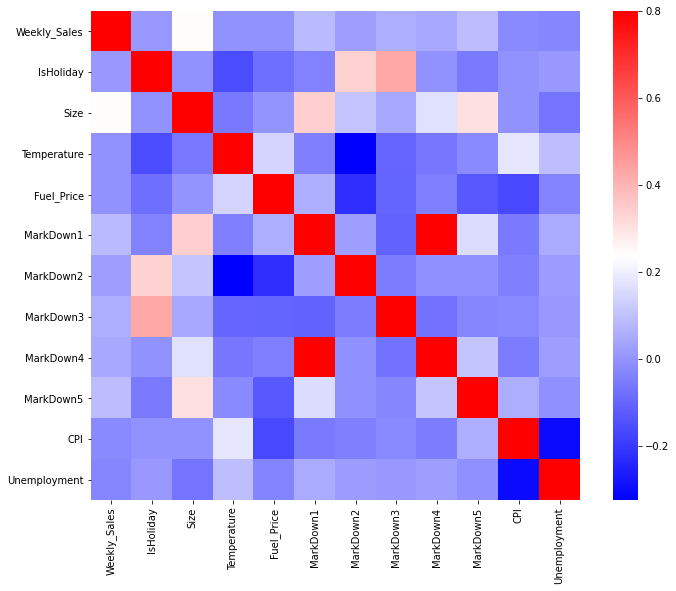

In [ ]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'bwr'
sns.heatmap(corrmat, vmax=.8, square=True, cmap=cmap);
# sns.heatmap(corrmat, vmax=.8, square=True, cmap='coolwarm');

Above we can observe that `MarkDown1` and `MarkDown4` are highly correlated to one another (multicollinearity). Meaning that we could get rid of one of these, in case we might use them to build our model.

Filtering the training data to the start of the when the markdowns started to be collected. 

In [ ]:
# markdowns started on Nov 2011
tmp = df_train[df_train['Date'] >= '2011-11-11']

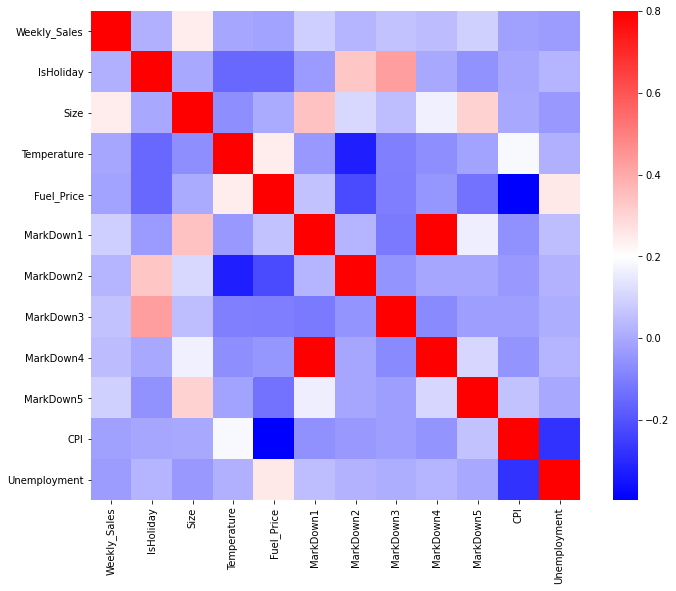

In [ ]:
#correlation matrix
corrmat = tmp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='bwr');

The markdowns do not show a high correlation with the target variable. Therefore, we might not have a meaningfull gain sacrificing a great part of our dataset to use them in the model.
We'll see their importance later on our feature selection. 

### Further Explore the data 

Let's make some plots to check whether we can perceive some insights on the data relations.

#### Type x Weekly_Sales

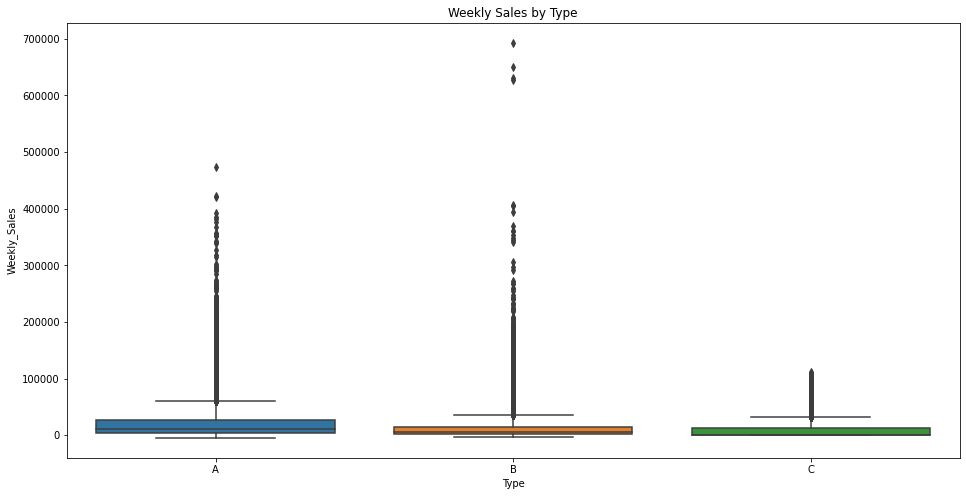

In [ ]:
# boxplot
var = 'Type'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by Type")
# fig.axis(ymin=0, ymax=800000)
# plt.xticks(rotation=90)

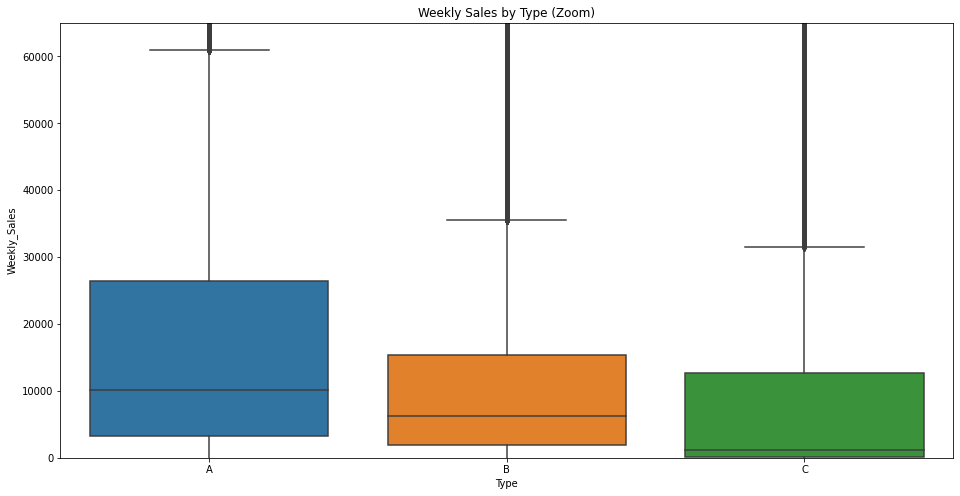

In [ ]:
# boxplot
var = 'Type'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=65000)
_ = plt.title("Weekly Sales by Type (Zoom)")

The types of stores have different means, nonetheless they all have lots of outliers.

It's clear that store A > B > C in terms of sales.

#### IsHoliday x Weekly_Sales

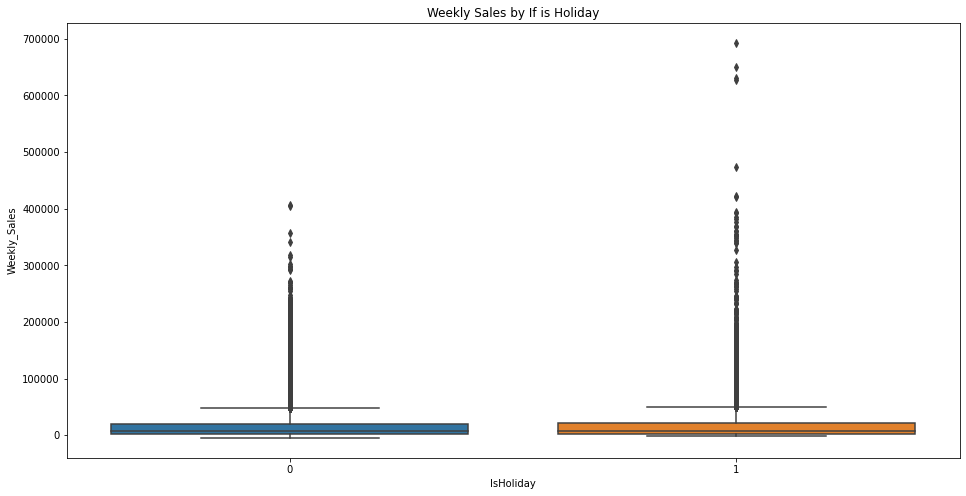

In [ ]:
# boxplot
var = 'IsHoliday'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by If is Holiday")
# fig.axis(ymin=0, ymax=800000)
# plt.xticks(rotation=90)

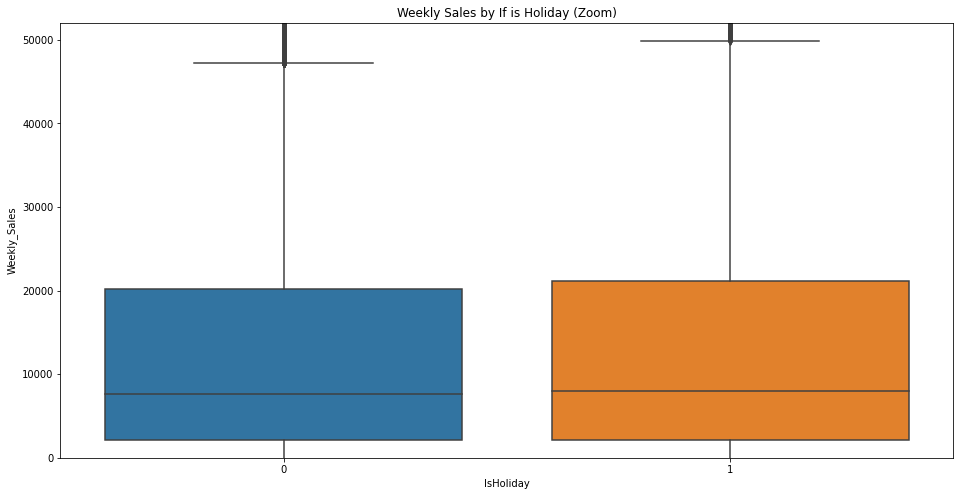

In [ ]:
# boxplot
var = 'IsHoliday'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=52000)
_ = plt.title("Weekly Sales by If is Holiday (Zoom)")

It seems it's not big the difference between sales on holidays or not. Nonetheless, there are a few more outliers on holidays' sales

#### Week x Weekly_Sales

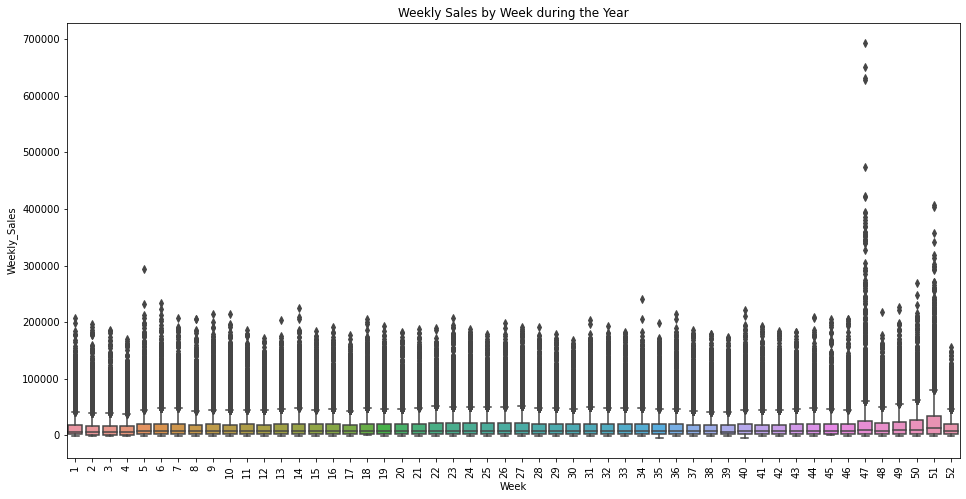

In [ ]:
# boxplot
var = 'Week'
data = pd.concat([df_train['Weekly_Sales'], df_train[var].astype('int')], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
# _ = fig.axis(ymin=0, ymax=52000)
_ = plt.xticks(rotation=90)
_ = plt.title("Weekly Sales by Week during the Year")

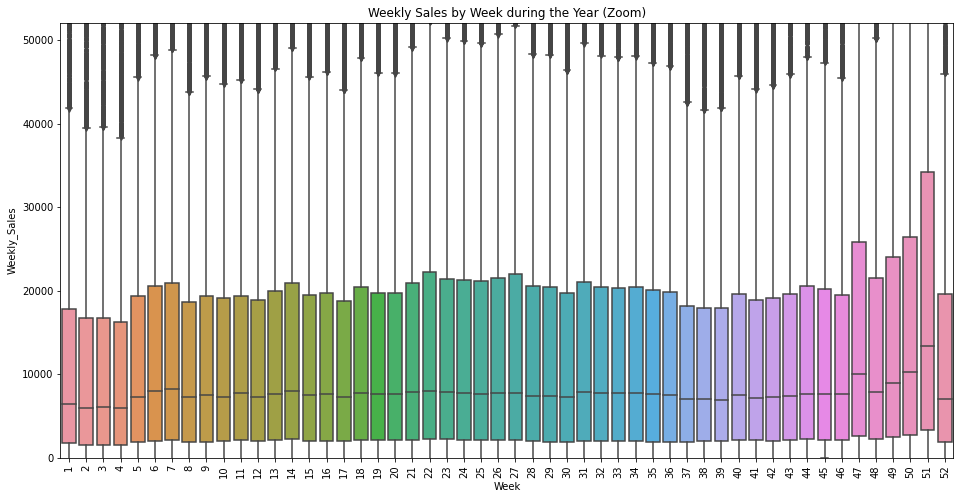

In [ ]:
# boxplot
var = 'Week'
data = pd.concat([df_train['Weekly_Sales'], df_train[var].astype('int')], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=52000)
_ = plt.xticks(rotation=90)
_ = plt.title("Weekly Sales by Week during the Year (Zoom)")

The sales increase with the ending of the year. The penultimate week is the one with higher mean sales during the year.

#### Month x Weekly_Sales

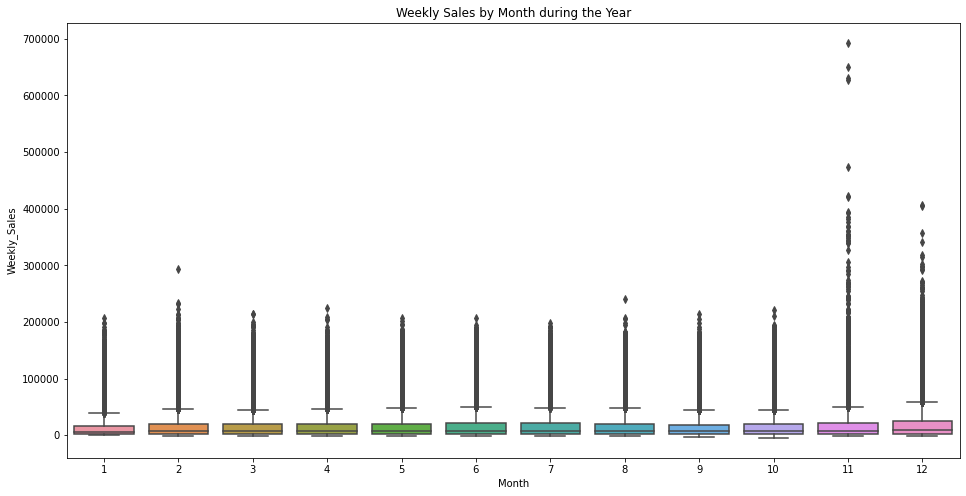

In [ ]:
# boxplot
var = 'Month'
data = pd.concat([df_train['Weekly_Sales'], df_train[var].astype('int')], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
# _ = fig.axis(ymin=0, ymax=52000)
# _ = plt.xticks(rotation=90)
_ = plt.title("Weekly Sales by Month during the Year")

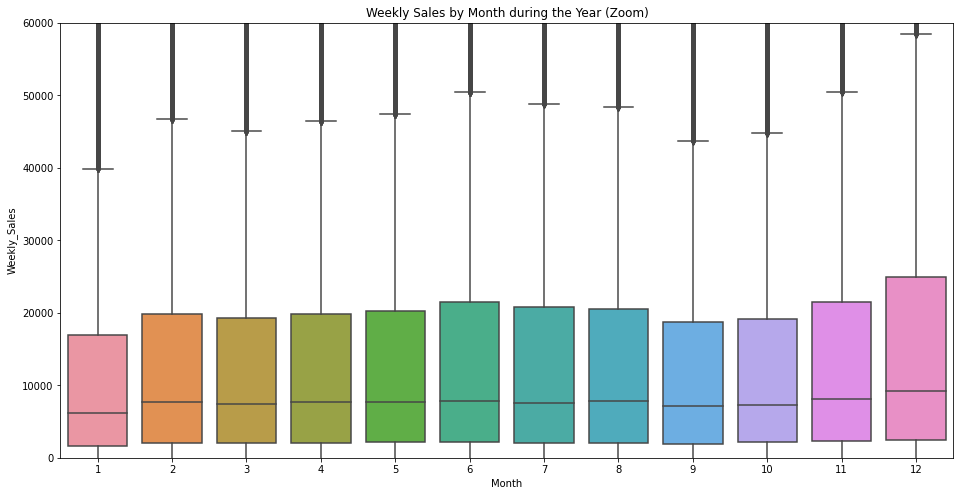

In [ ]:
# boxplot
var = 'Month'
data = pd.concat([df_train['Weekly_Sales'], df_train[var].astype('int')], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=60000)
# _ = plt.xticks(rotation=90)
_ = plt.title("Weekly Sales by Month during the Year (Zoom)")

There seem to have a increase in the middle of the year and at the end of the year. Seems seasonal, summerbreak and holidays.

#### Date x Weekly_Sales

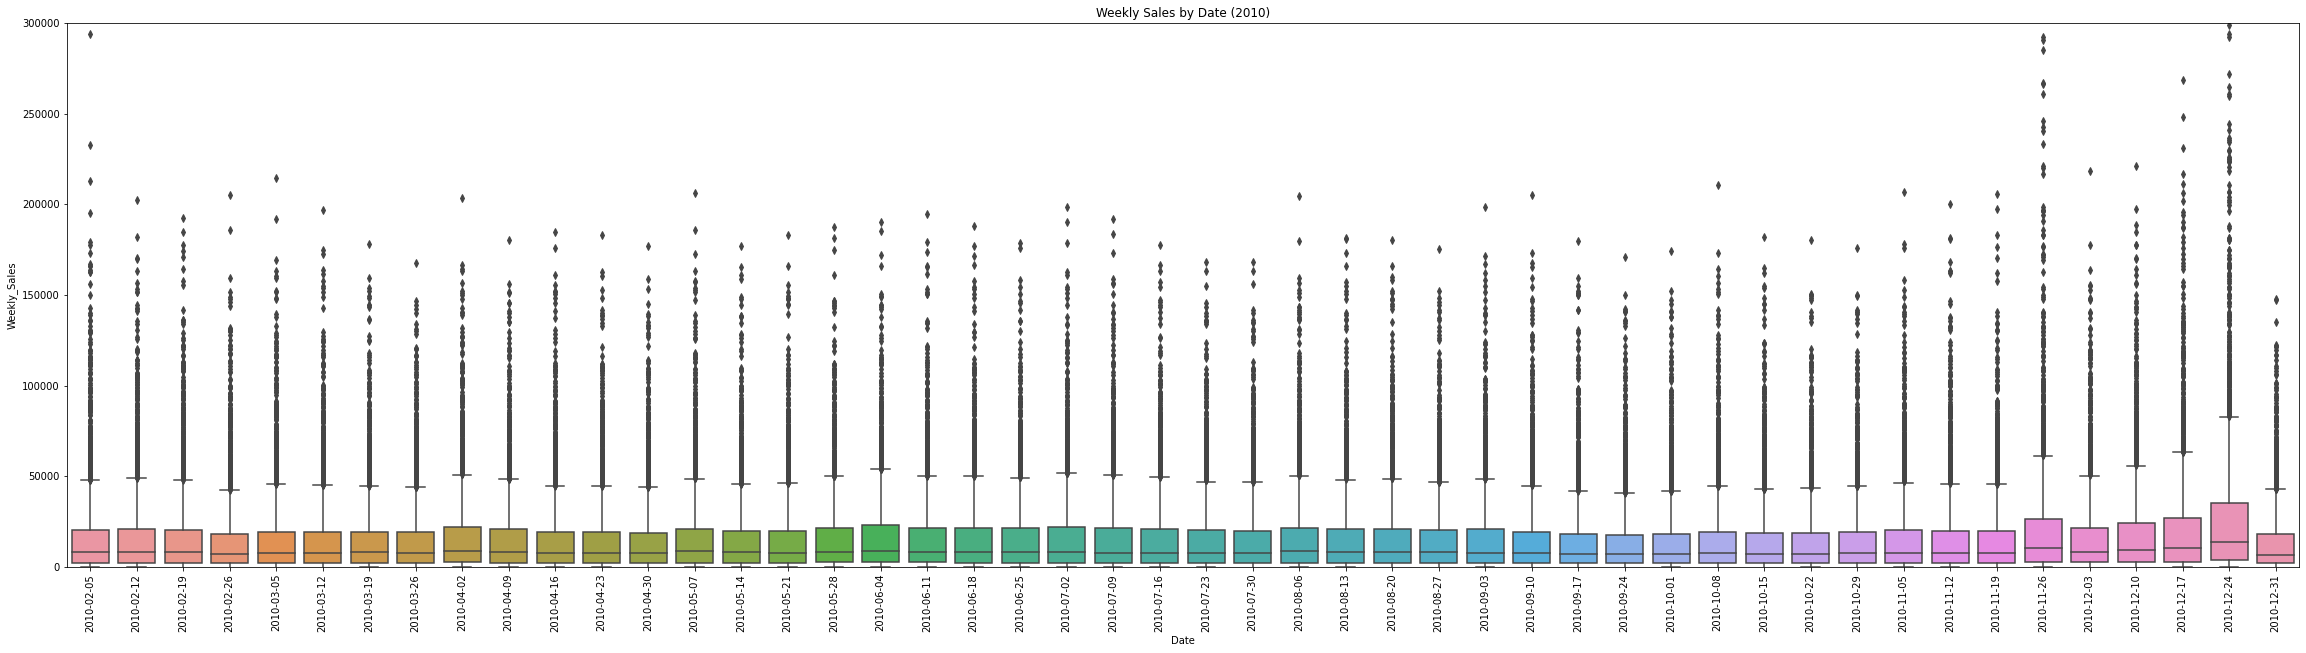

In [ ]:
# boxplot plot
var = 'Date'
year = '2010'
tmp = df_train[df_train[var].dt.year.astype(str) == year]

data = pd.concat([tmp['Weekly_Sales'], tmp[var].astype(str)], axis=1)
f, ax = plt.subplots(figsize=(40, 10))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=300000)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Date ({year})")

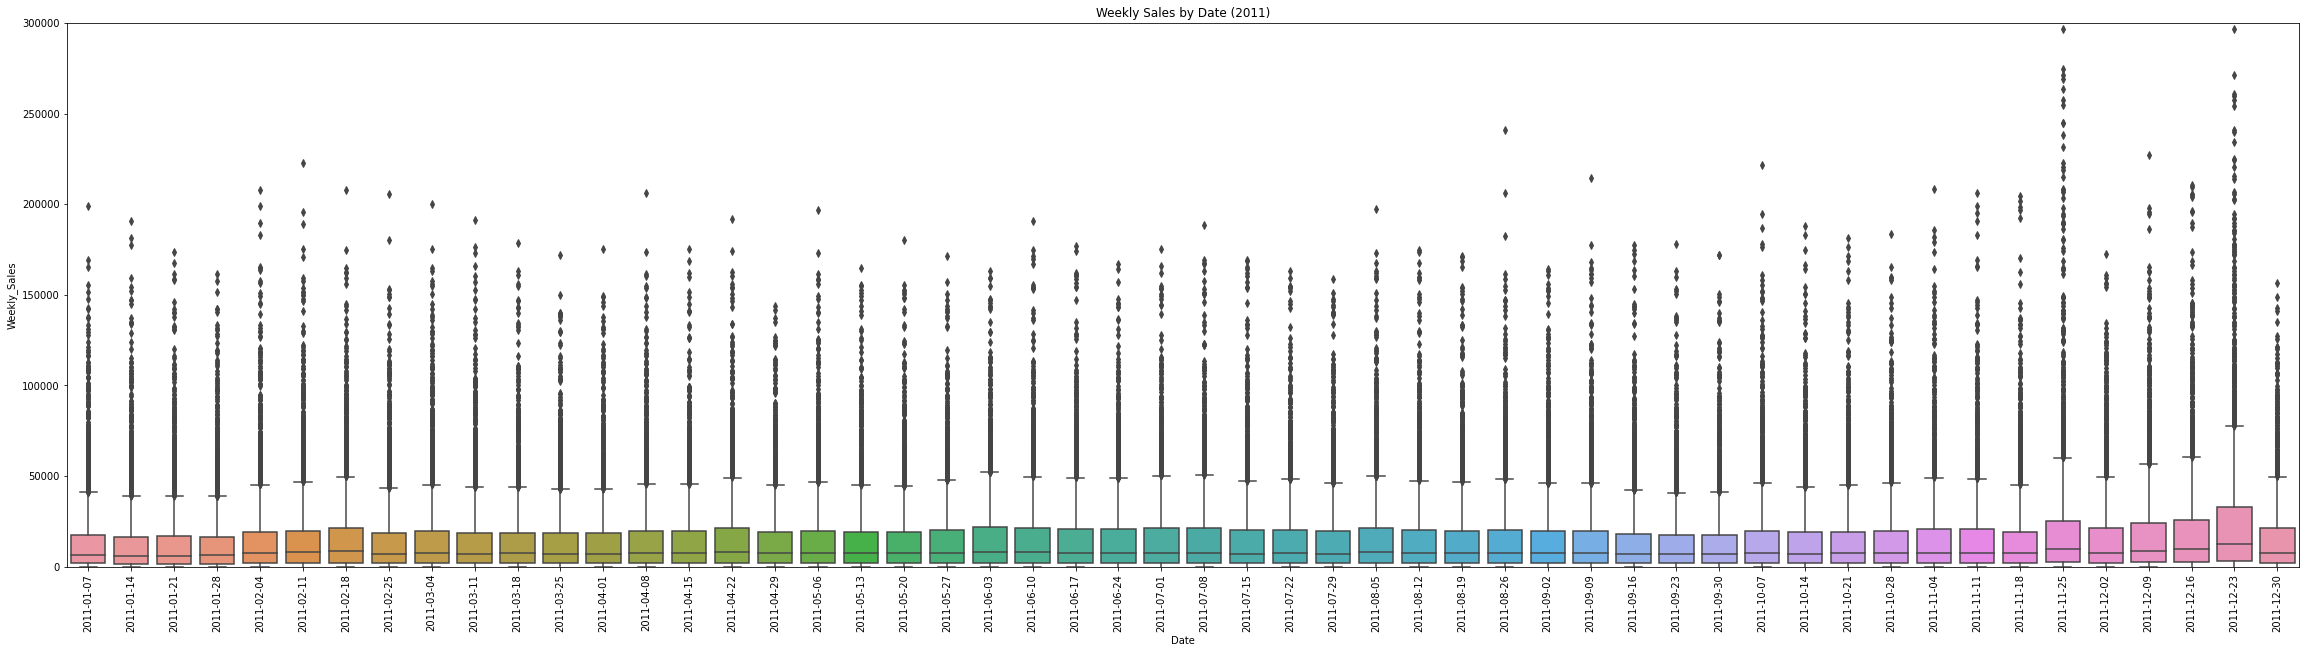

In [ ]:
# boxplot plot
var = 'Date'
year = '2011'
tmp = df_train[df_train[var].dt.year.astype(str) == year]

data = pd.concat([tmp['Weekly_Sales'], tmp[var].astype(str)], axis=1)
f, ax = plt.subplots(figsize=(40, 10))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=300000)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Date ({year})")

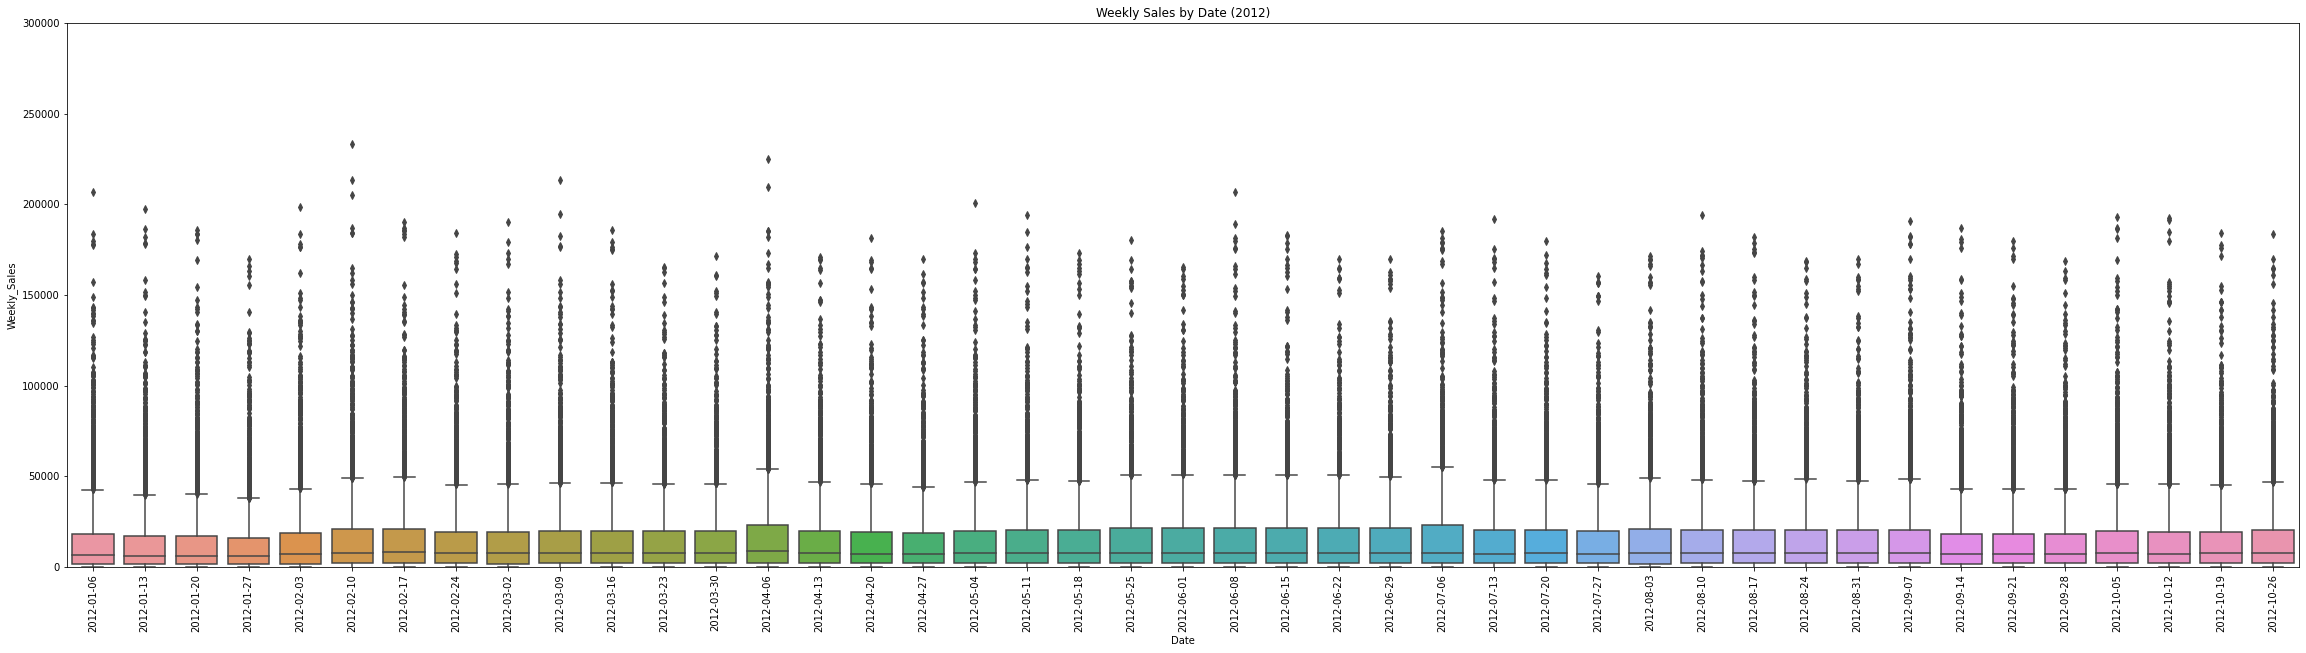

In [ ]:
# boxplot plot
var = 'Date'
year = '2012'
tmp = df_train[df_train[var].dt.year.astype(str) == year]

data = pd.concat([tmp['Weekly_Sales'], tmp[var].astype(str)], axis=1)
f, ax = plt.subplots(figsize=(40, 10))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = fig.axis(ymin=0, ymax=300000)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Date ({year})")

There is a similar behaviour of trend sales throughout the years.

#### Size x Weekly_Sales

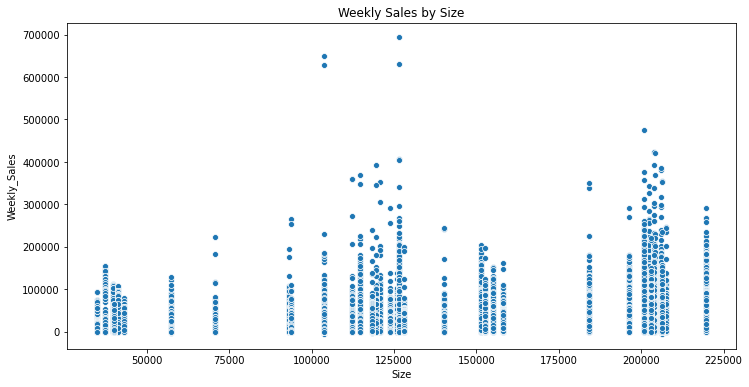

In [ ]:
#scatter plot
var = 'Size'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
# data.plot.scatter(x=var, y='Weekly_Sales')
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.scatterplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by Size")
# _ = plt.xticks(rotation=90)
# fig.axis(ymin=0, ymax=52000)

#### Dept x Weekly_Sales

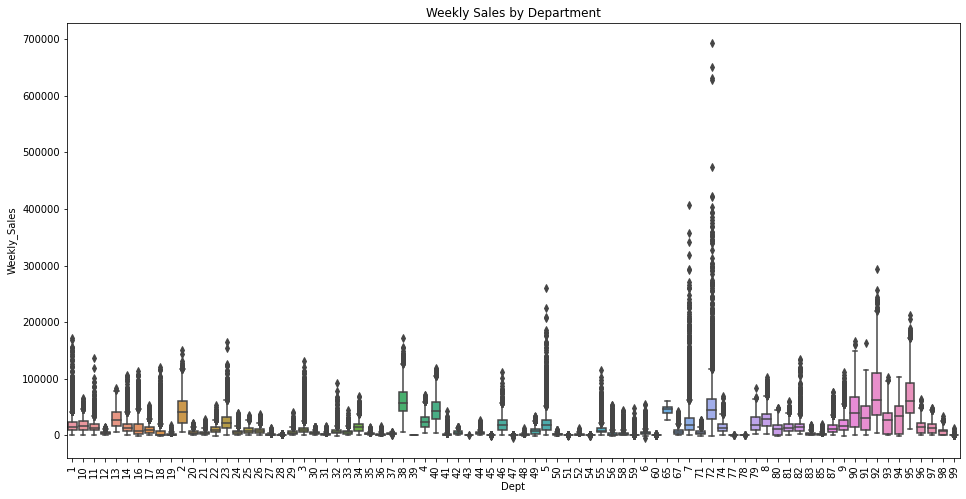

In [ ]:
# boxplot
var = 'Dept'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.xticks(rotation=90)
_ = plt.title("Weekly Sales by Department")
# fig.axis(ymin=0, ymax=52000)

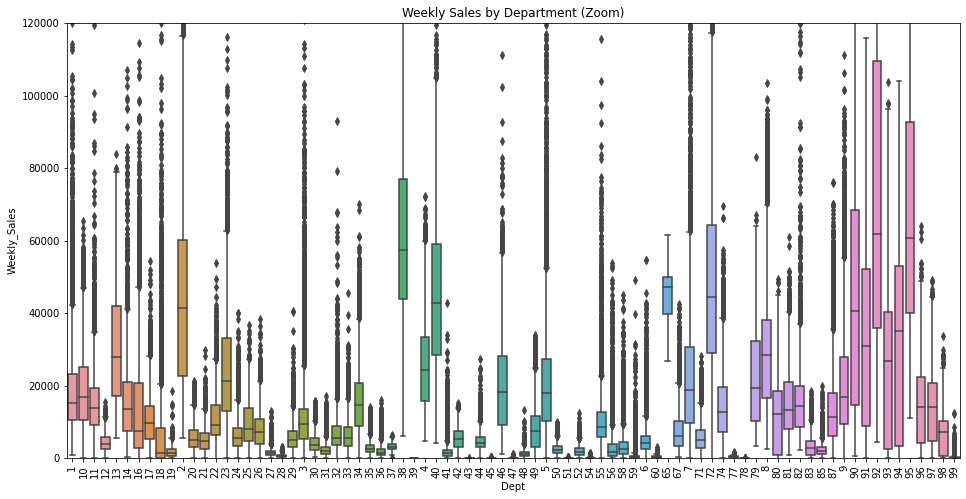

In [ ]:
# boxplot
var = 'Dept'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by Department (Zoom)")
_ = plt.xticks(rotation=90)
_ = fig.axis(ymin=0, ymax=120000)

It's clear that some departments sells much more than others.

#### Type x Dept x Weekly_Sales

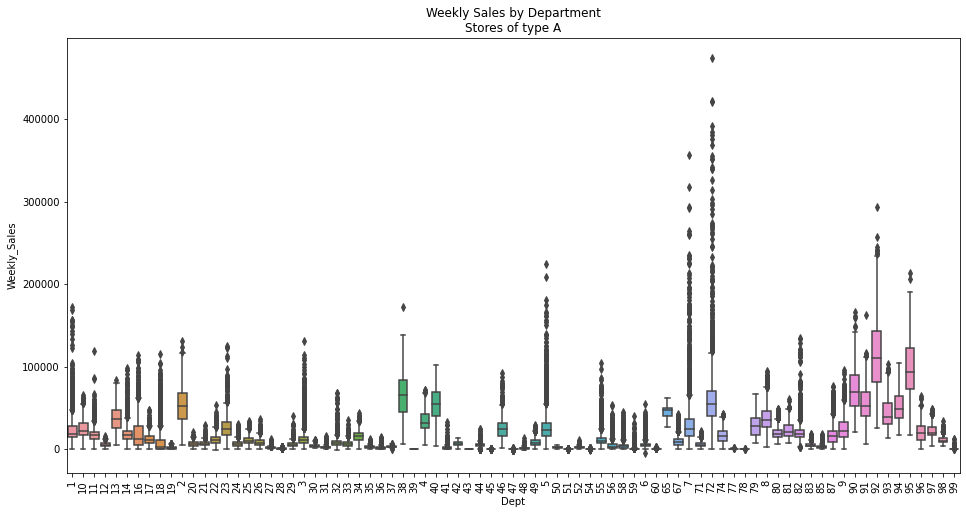

In [ ]:
# boxplot
var = 'Dept'
var2 = 'A'
tmp = df_train[df_train['Type'] == var2]
data = pd.concat([tmp['Weekly_Sales'], tmp[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Department\nStores of type {var2}")
# fig.axis(ymin=0, ymax=120000)

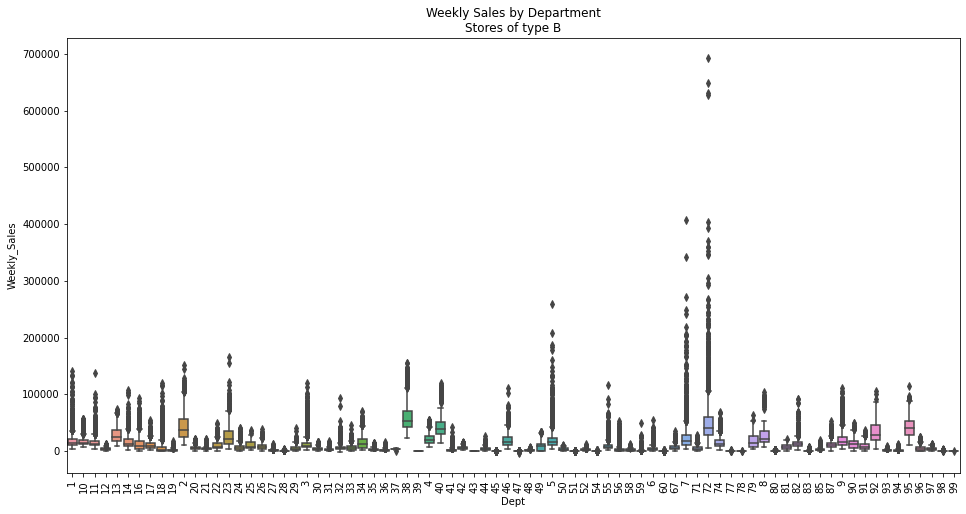

In [ ]:
# boxplot
var = 'Dept'
var2 = 'B'
tmp = df_train[df_train['Type'] == var2]
data = pd.concat([tmp['Weekly_Sales'], tmp[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Department\nStores of type {var2}")
# fig.axis(ymin=0, ymax=120000)

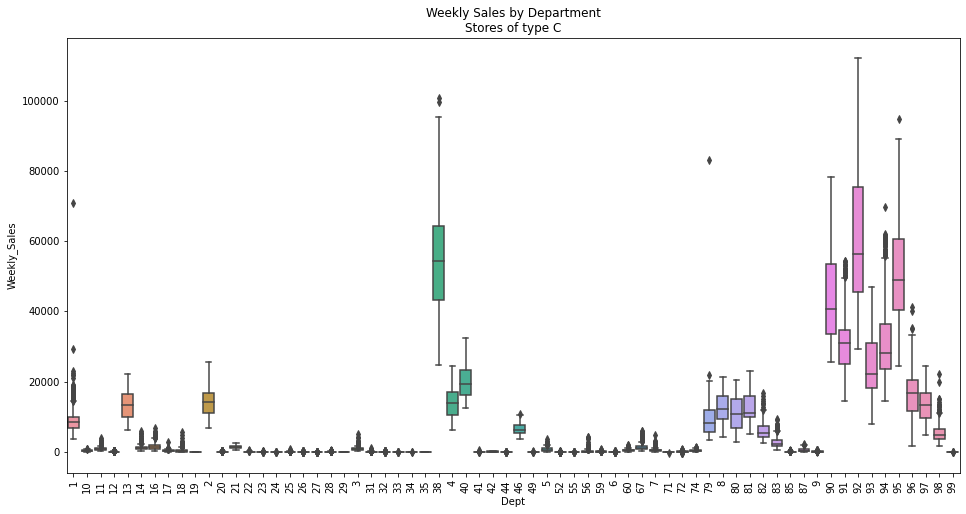

In [ ]:
# boxplot
var = 'Dept'
var2 = 'C'
tmp = df_train[df_train['Type'] == var2]
data = pd.concat([tmp['Weekly_Sales'], tmp[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Weekly_Sales", data=data)
_ = plt.xticks(rotation=90)
_ = plt.title(f"Weekly Sales by Department\nStores of type {var2}")
# fig.axis(ymin=0, ymax=120000)

#### Fuel_Price x Weekly_Sales

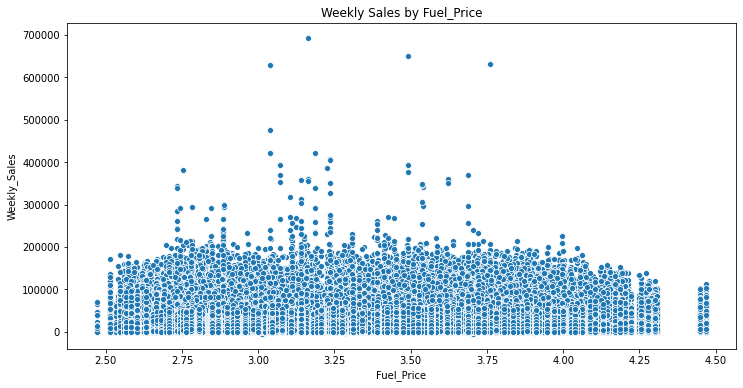

In [ ]:
#scatter plot
var = 'Fuel_Price'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.scatterplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by Fuel_Price")

#### Temperature x Weekly_Sales

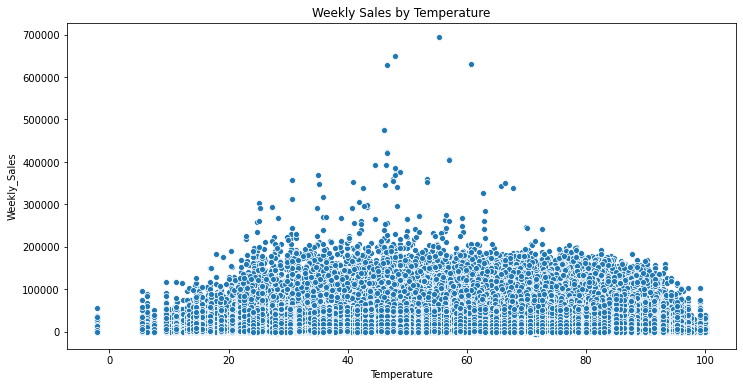

In [ ]:
#scatter plot
var = 'Temperature'
data = pd.concat([df_train['Weekly_Sales'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.scatterplot(x=var, y="Weekly_Sales", data=data)
_ = plt.title("Weekly Sales by Temperature")

Middler temperatures reflect on more sales maybe.

#### Weekly_Sales (Target)

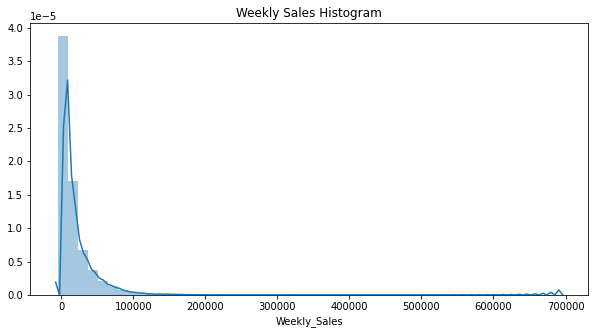

In [ ]:
# histogram
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.distplot(df_train['Weekly_Sales'])
_ = plt.title("Weekly Sales Histogram")

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_train['Weekly_Sales'].skew())
print("Kurtosis: %f" % df_train['Weekly_Sales'].kurt())

Skewness: 3.262008
Kurtosis: 21.491290


- The distribution is not symmetrical (highly skewed).

- The distribution is too peaked (high Kurtosis)

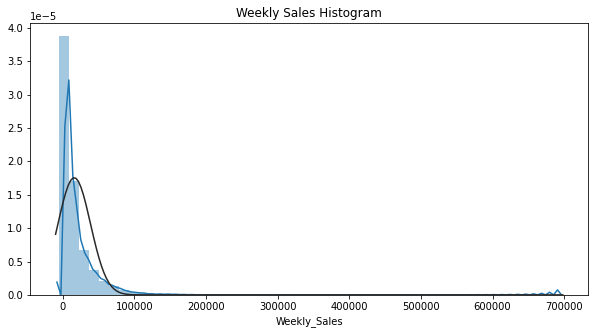

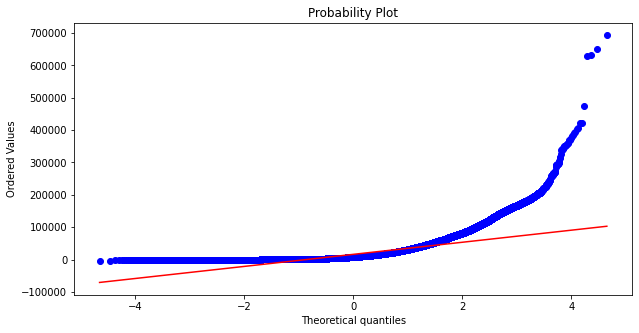

In [ ]:
# histogram and normal probability plot
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_train['Weekly_Sales'], fit=norm)
_ = plt.title("Weekly Sales Histogram")

f, ax = plt.subplots(figsize=(10, 5))
res = stats.probplot(df_train['Weekly_Sales'], plot=plt)

As I'm planning on using a decision tree for the model I won't change the distribution of the target variable as they are not sensitive to skewness and outliers.

## Feature Selection

As we are going to experiment on Tree models (and maybe on time-series model later) there is no need to scale our datasets.

But we'll take care of the Null values.



### Transform Dataset

We'll create a final function to transform our datasets according to all knowledge we've gathered throughout our data exploration and analysis.

In [ ]:
# load the datasets
base_folder = '/tmp/walmart-recruiting-store-sales-forecasting'

df_train = pd.read_csv(base_folder + '/train.csv.zip')
df_test = pd.read_csv(base_folder + '/test.csv.zip')
df_stores = pd.read_csv(base_folder + '/stores.csv')
df_features = pd.read_csv(base_folder + '/features.csv.zip')

In [ ]:
def mergeTransformDatasets(df_train, df_stores, df_features):
    """
    Merge and Transform the Walmart datasets
    """
    tmp = pd.merge(df_train, df_stores, on=['Store'])
    # drop not to duplicate column when merged
    df_features = df_features.drop(columns=['IsHoliday'])
    tmp = pd.merge(tmp, df_features, on=['Store', 'Date'])

    # convert isHoliday to int
    tmp['IsHoliday'] = (tmp['IsHoliday'] == True).astype(int)

    # replace Types by number equivalent
    tmp['Type'] = tmp['Type'].replace('A', '1')
    tmp['Type'] = tmp['Type'].replace('B', '2')
    tmp['Type'] = tmp['Type'].replace('C', '3')

    # convert to categorical
    tmp['Store'] = tmp['Store'].astype(str)
    tmp['Dept'] = tmp['Dept'].astype(str)

    # convert Date to datetime type
    tmp['Date'] = pd.to_datetime(tmp['Date'])

    # create columns month and week
    tmp['Month'] = tmp['Date'].dt.month.astype(str)
    tmp['Week'] = tmp['Date'].dt.week.astype(str)

    return tmp

In [ ]:
# merge datasets
df_train = mergeTransformDatasets(df_train, df_stores, df_features)
df_test = mergeTransformDatasets(df_test, df_stores, df_features)

In [ ]:
# kept the same number of rows
print(df_train.shape)
print(df_test.shape)

(421570, 18)
(115064, 17)


In [ ]:
df_train.dtypes

Store                   object
Dept                    object
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Month                   object
Week                    object
dtype: object

### Dealing with missing data

In [ ]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
MarkDown2,310322,0.736110
MarkDown4,286603,0.679847
MarkDown3,284479,0.674808
MarkDown1,270889,0.642572
MarkDown5,270138,0.640790
Week,0,0.000000
Type,0,0.000000


We'll replace the Null values of the Markdowns with zero before we make the feature selection.

In [ ]:
# replace Null values with zero
values = {'MarkDown1': 0, 
          'MarkDown2': 0, 
          'MarkDown3': 0, 
          'MarkDown4': 0, 
          'MarkDown5': 0}

df_train = df_train.fillna(value=values)

In [ ]:
# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
Week,0,0.0
Month,0,0.0
Dept,0,0.0
Date,0,0.0
Weekly_Sales,0,0.0
IsHoliday,0,0.0
Type,0,0.0


### Random Tree model for feature selection

Let's use a decision tree model to be able to measure how important each of our features are to predict the sales. 

We can select only the most important ones to build our model, so it keeps simpler and more generic to make new predictions.

In [ ]:
# show data types
df_train.dtypes

Store                   object
Dept                    object
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Month                   object
Week                    object
dtype: object

In [ ]:
# create a initial model for feature selection purposes
model_fs = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [ ]:
start = time()

# fit with all training data for feature selection purposes
model_fs.fit(df_train.drop(columns=['Weekly_Sales', 'Date']), df_train['Weekly_Sales'])

print(f"Execution time: {time() - start:.2f} seconds.")

Execution time: 313.01 seconds.


In [ ]:
# 20 most important features for better visualization
feat_importances = pd.Series(model_fs.feature_importances_, index=df_train.drop(columns=['Weekly_Sales', 'Date']).columns)
n_feat_importances = feat_importances.nlargest(20)

In [ ]:
# the feature importances sum to 1 (100% explained by those features)
feat_importances.sum()

1.0

In [ ]:
# the 8 most important features sum up to 97% explainability of the model
feat_importances.nlargest(8).sum()

0.9766068373008453

In [ ]:
n_feat_importances

Dept            0.629560
Size            0.189070
Store           0.057369
Week            0.039885
CPI             0.025862
Type            0.014312
Unemployment    0.010631
Temperature     0.009918
Month           0.006787
MarkDown3       0.005249
Fuel_Price      0.004913
MarkDown4       0.001741
IsHoliday       0.001378
MarkDown5       0.001205
MarkDown1       0.001120
MarkDown2       0.000999
dtype: float64

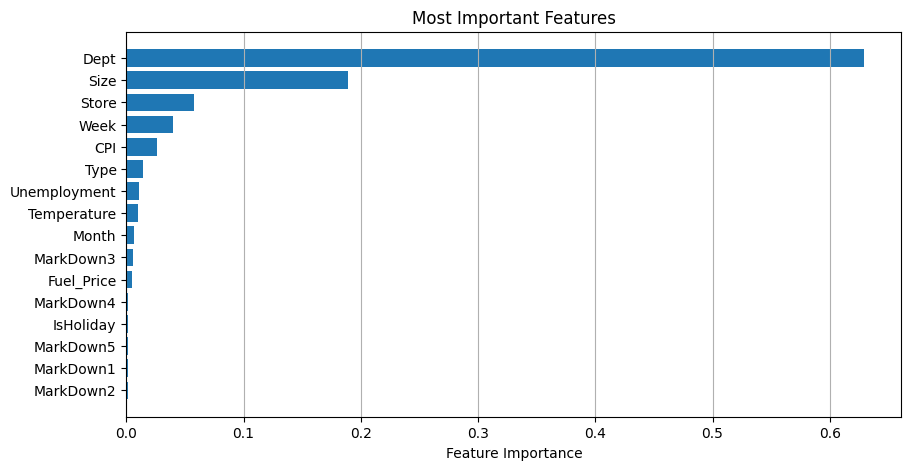

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))

# Example data
feats = n_feat_importances.index.to_list()
y_pos = np.arange(len(feats))
feats_imp = n_feat_importances.to_list()

ax.barh(y_pos, feats_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Most Important Features')
ax.grid(axis='x')

plt.show()

### Split the datasets

We'll split the training data in train, test and validation.

- Train is used to train the model.
- Validation is used to find the best hiperparams of the model.
- Test is used for final evaluation of the model.

Obs. The test.csv.zip file contains unseen data, therefore will only be used to create a final submission file for kaggle (imagine it as an unseen future we're predicting).

In [ ]:
# train test split 70/30%
df_train, df_test = train_test_split(df_train, test_size=0.3)

# train validation split 90/10%
df_train, df_val = train_test_split(df_train, test_size=0.1)

In [ ]:
print(f"train shape:      {df_train.shape}")
print(f"validation shape: {df_val.shape}")
print(f"test shape:       {df_test.shape}")

train shape:      (265589, 18)
validation shape: (29510, 18)
test shape:       (126471, 18)


In [ ]:
# separate the features from labels
X_train = df_train.drop(['Weekly_Sales'], axis=1)
y_train = df_train.Weekly_Sales

X_val = df_val.drop(['Weekly_Sales'], axis=1)
y_val = df_val.Weekly_Sales

X_test = df_test.drop(['Weekly_Sales'], axis=1)
y_test = df_test.Weekly_Sales

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (265589, 17)
y_train shape: (265589,)
X_val shape:   (29510, 17)
y_val shape:   (29510,)
X_test shape:  (126471, 17)
y_test shape:  (126471,)


In [ ]:
X_train.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Week
65006,7,30,2011-10-14,0,2,70713,32.65,3.491,0.00,0.00,0.00,0.00,0.00,195.026101,8.513,10,41
263965,27,90,2012-01-06,0,1,204184,35.80,3.585,9235.59,29675.22,526.36,2399.37,6290.52,140.646136,8.009,1,1
330606,34,82,2012-10-12,0,1,158114,59.94,3.603,2254.65,0.00,29.82,524.12,7604.92,131.108333,8.839,10,41
114745,12,13,2012-01-13,0,2,112238,48.07,3.657,6935.50,23438.57,0.00,2289.80,9526.73,130.244000,12.187,1,2
360857,38,97,2012-09-28,0,3,39690,81.22,3.966,201.62,0.00,0.00,29.21,802.50,131.043000,10.926,9,39


## Create Model

### Random Forest: Hiperparameter Tunning

Let's build a grid search model with the 8 most important features to find the best params to use.

In [ ]:
# make feature selection - 8 most important
selected_features = feat_importances.nlargest(8).index.to_list()

In [ ]:
selected_features

['Dept', 'Size', 'Store', 'Week', 'CPI', 'Type', 'Unemployment', 'Temperature']

The grid search might take a couple of hours to completely execute.

In [ ]:
# Random forest model
model = RandomForestRegressor(n_jobs=-1)

# Grid search for hiperparam
param_grid = {"n_estimators": [100, 200],
              "max_depth": [2, 3, None],
              "max_features": ['auto'],
              "min_samples_leaf": [1, 2, 3]}

# Execute Grid Search on model
grid_search = GridSearchCV(model, 
                           param_grid = param_grid, 
                           return_train_score = True, 
                           n_jobs=-1)

start = time()
# Train the grid
grid_search.fit(X_train[selected_features], y_train)

print(f"Execution time: {time() - start:.2f} seconds.")

Execution time: 6099.90 seconds.


In [ ]:
# print the mean cv score for each parameters 
#for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
#    print(f"{str(params):<52}   =>   {score}")

#### Best Hiperparams

The grid search tests a list of params a gives us the combination that resulted on the best result.

In [ ]:
# print the best parameters and the best score
grid_search.best_params_, grid_search.best_score_

({'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'n_estimators': 200},
 0.9711474323374667)

In [ ]:
# evaluate the R2 score using the validation dataset
grid_search.best_estimator_.score(X_val[selected_features], y_val)

0.9723030918744117

R2 score is a measure of how well our model fits a set of observations. In our case the strength of the relationship between your model and the response variable is 97%.

#### RMSE for validation dataset

RMSE shows how much our predictions deviate, on average, from the actual values in the dataset.

In [ ]:
# prediction for validation dataset
y_hat_val = grid_search.best_estimator_.predict(X_val[selected_features])

In [ ]:
# RMSE for validation prediction
rmse_val = sqrt(mean_squared_error(y_val, y_hat_val))
print(f"RMSE for validation dataset is: {rmse_val:.2f}")

RMSE for validation dataset is: 3762.85


This means that when we make a prediction, the actual value might be on average $3700 more or less than we have predicted.

### Create Model with chosen params

We'll create a new model using the best params and use both **train + validation** data to train our final model.

In [ ]:
# concatenate train and validation sets
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [ ]:
# create a new model using the best parameters of the grid search
model = RandomForestRegressor(n_jobs=-1, **grid_search.best_params_)

In [ ]:
# train the model with the selected features

start = time()
# Train the grid
model.fit(X_train_val[selected_features], y_train_val)

print(f"Execution time: {time() - start:.2f} seconds.")

Execution time: 270.03 seconds.


Now we can use the test set to check if the trained model generalizes to the unseen data.

In [ ]:
model.score(X_test[selected_features], y_test)

0.9718592464631374

The R2 score is similar to the previous one.

#### RMSE for test dataset

In [ ]:
# prediction for validation dataset
y_hat_test = model.predict(X_test[selected_features])

In [ ]:
# RMSE for validation prediction
rmse_test = sqrt(mean_squared_error(y_test, y_hat_test))
print(f"RMSE for test dataset is: {rmse_test:.2f}")

RMSE for test dataset is: 3813.97


The RMSE and R2 scores of the test data is similar to the previous scores results from the validation data. That means that our model performs ass well as they did when applying to unseen data. 

### Create Final Model with full dataset

Now that we selected the most important features, selected the best hiperparams and checked the error score of the our models, it is time to create a final model.

We'll use all our training dataset to train this model and then we can make predictions on unseen future data.

In [ ]:
# concatenate train and validation sets
X_train_full = pd.concat([X_train_val, X_test], axis=0)
y_train_full = pd.concat([y_train_val, y_test], axis=0)

In [ ]:
# create a new model using the best parameters of the grid search
model = RandomForestRegressor(n_jobs=-1, **grid_search.best_params_)

In [ ]:
# train the final model with the selected features

start = time()
# Train the grid
model.fit(X_train_full[selected_features], y_train_full)

print(f"Execution time: {time() - start:.2f} seconds.")

Execution time: 420.15 seconds.


## Prepare the file for submission

#### Load the test dataset

New we'll load the test dataset (unseen data) to make our final predictions.

In [ ]:
# load the datasets
base_folder = '/tmp/walmart-recruiting-store-sales-forecasting'

df_test = pd.read_csv(base_folder + '/test.csv.zip')
df_stores = pd.read_csv(base_folder + '/stores.csv')
df_features = pd.read_csv(base_folder + '/features.csv.zip')

In [ ]:
# merge datasets
df_test = mergeTransformDatasets(df_test, df_stores, df_features)

In [ ]:
df_test.shape

(115064, 17)

#### Deal with missing data

`Unemployment` and `CPI` are the only missing data that will be fed to our model. We'll fill the last missing values with the previous ones.

In [ ]:
# missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
Unemployment,38162,0.331659
CPI,38162,0.331659
MarkDown2,28627,0.248792
MarkDown4,12888,0.112007
MarkDown3,9829,0.085422
MarkDown1,149,0.001295
Size,0,0.000000


`Unemployment` and `CPI` are the only selected features with missing data to be fed to our final model.

These features have the last months missing, so we're going to fill these missing values with the latest values present in every store, as these values differs from each region. 

In [ ]:
# Propagate last valid observation forward according to store and date
df_test = df_test.sort_values(by=['Store', 'Date', 'Unemployment'], ascending=True, na_position='last')
df_test['Unemployment'] = df_test['Unemployment'].fillna(method='ffill')
df_test['CPI'] = df_test['CPI'].fillna(method='ffill')

In [ ]:
# missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
MarkDown2,28627,0.248792
MarkDown4,12888,0.112007
MarkDown3,9829,0.085422
MarkDown1,149,0.001295
Temperature,0,0.000000
Dept,0,0.000000
Date,0,0.000000


### Make final predictions

Now we're ready to make our final predictions.

In [ ]:
df_test.shape

(115064, 17)

In [ ]:
# prediction for validation dataset
y_hat_test = model.predict(df_test[selected_features])

In [ ]:
y_hat_test.shape

(115064,)

### Prepare the submission file

We're going to mold our results as submission sample example. We'll create an `Id` column concatenating the columns `Store + Dept + Date` and order it.  

In [ ]:
# concatenate train and validation sets
y_hat_test = pd.DataFrame(y_hat_test, columns=['Weekly_Sales'])
df_final_sub = pd.concat([df_test[['Store', 'Dept', 'Date']], y_hat_test], axis=1)

# make sure the order is correct
df_final_sub['Store'] = df_final_sub['Store'].astype(int)
df_final_sub['Dept'] = df_final_sub['Dept'].astype(int)
df_final_sub = df_final_sub.sort_values(by=['Store', 'Dept', 'Date'], ascending=True)

In [ ]:
df_final_sub.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2012-11-02,31425.9448
71,1,1,2012-11-09,18765.5109
142,1,1,2012-11-16,18807.0113
213,1,1,2012-11-23,19474.2077
285,1,1,2012-11-30,22758.6921


In [ ]:
# convert to string 
df_final_sub['Store'] = df_final_sub['Store'].astype(str)
df_final_sub['Dept'] = df_final_sub['Dept'].astype(str)
df_final_sub['Date'] = df_final_sub['Date'].astype(str)

# create the Id column
df_final_sub['Id'] = df_final_sub[['Store', 'Dept', 'Date']].agg('_'.join, axis=1)

In [ ]:
df_final_sub = df_final_sub[['Id', 'Weekly_Sales']]

In [ ]:
df_final_sub.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,31425.9448
71,1_1_2012-11-09,18765.5109
142,1_1_2012-11-16,18807.0113
213,1_1_2012-11-23,19474.2077
285,1_1_2012-11-30,22758.6921


### Create and submit final prediction file

Now we just have to write the file and submit it. We're using the Kaggle API for the final submission, but you can do it manually on the kaggle website.

In [ ]:
base_folder = '/tmp/walmart-recruiting-store-sales-forecasting'
submission_file = f"{base_folder}/submission.csv"

# create csv file
df_final_sub.to_csv(submission_file, sep=',', header=True, index=False)

Now we can submit the submission file via kaggle api.

In [ ]:
! kaggle competitions submit -c walmart-recruiting-store-sales-forecasting -f /tmp/walmart-recruiting-store-sales-forecasting/submission.csv -m "Random_Forest_01"

100% 3.77M/3.77M [00:07<00:00, 529kB/s]
Successfully submitted to Walmart Recruiting - Store Sales Forecasting

## Conclusion

This was a first attempt to tackle this challenge. 

We did an extensive data exploration and data analysis, feature selection, hiperparams tunning and final model creation to reach to our final predictions.


Other transformations on the data, such as feature scaling and normalization were not necessary regarding to the tree model that was selected.


We could try several other models to see whether they result in a better outcome. We could also try enriching the dataset with new data, or even ensemble multiple models, but let's leave it to the next time. 